# Convolutional Autoencoder with a human-friendly latent space

Autoencoders seems very useful for a design application. If we can use an AI to parametrize a large dataset of examples, the designer can use the parameters to create new design.

One problem with autoencoders is that they parametrize in a non-human way. In this experiment i test a way of forcing the AI to create a latent space that is interpretable.

It uses the same dimensions of all convolutional layers, but reduces the dimensionality by having a "maxlayer" that basically creates one-hot vectors. 8 of these layers combines into the input for the decoder.

Based on this notebook:
https://github.com/mchablani/deep-learning/blob/master/autoencoder/Convolutional_Autoencoder.ipynb



In [10]:
%matplotlib inline

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os

In [11]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', validation_size=0)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


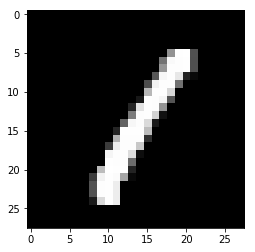

In [12]:
img = mnist.train.images[3]
plt.imshow(img.reshape((28, 28)), cmap='Greys_r')

In [13]:
#NEWEST


learning_rate = 0.001
# Input and target placeholders
inputs_ = tf.placeholder(tf.float32, (None, 28,28,1), name="input")
targets_ = tf.placeholder(tf.float32, (None, 28,28,1), name="target")

def encoder(input_x):
    x = tf.layers.conv2d(inputs=input_x, filters=16, kernel_size=(5,5), padding='same', activation=tf.nn.relu)
    x = tf.layers.conv2d(inputs=x, filters=16, kernel_size=(5,5), padding='same', activation=tf.nn.relu)
    x = tf.layers.conv2d(inputs=x, filters=8, kernel_size=(5,5), padding='same', activation=tf.nn.sigmoid)
    x = tf.multiply(x,input_x)
    return x

def maxlayer(x):
    x_max = tf.reduce_max(x, axis=1, keep_dims=True)
    x_max = tf.reduce_max(x_max, axis=2, keep_dims=True)
    x = tf.equal(x,x_max)
    x = tf.cast(x,tf.float32)
    x = tf.reduce_max(x, axis=3, keep_dims=True)
    return x

def decoder(input_x):
    x = tf.layers.conv2d(inputs=input_x, filters=16, kernel_size=(5,5), padding='same', activation=tf.nn.relu)
    x = tf.layers.conv2d(inputs=x, filters=16, kernel_size=(5,5), padding='same', activation=tf.nn.relu)
    x = tf.layers.conv2d(inputs=x, filters=16, kernel_size=(5,5), padding='same', activation=tf.nn.relu)
    logits = tf.layers.conv2d(inputs=x, filters=1, kernel_size=(5,5), padding='same', activation=None)
    return logits

encoded=maxlayer(encoder(inputs_))

logits=decoder(encoded)

# Pass logits through sigmoid to get reconstructed image
decoded = tf.nn.sigmoid(logits)

# Pass logits through sigmoid and calculate the cross-entropy loss
loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=targets_, logits=logits)

# Get cost and define the optimizer
cost = tf.reduce_mean(loss)
opt = tf.train.AdamOptimizer(learning_rate).minimize(cost)

## Training

In [16]:
sess = tf.Session()
epochs = 10
batch_size = 200
sess.run(tf.global_variables_initializer())
saver = tf.train.Saver()
#saver.restore(sess,os.getcwd()+"/saved_model/model.ckpt")

for e in range(epochs):
    for ii in range(mnist.train.num_examples//batch_size):
        batch = mnist.train.next_batch(batch_size)
        imgs = batch[0].reshape((-1, 28, 28, 1))
        do_maxlayer=(np.random.rand()>0.05)
        batch_cost, _ = sess.run([cost, opt], feed_dict={inputs_: imgs,
                                                         targets_: imgs})
        if ii%20==0:
            imgs = mnist.test.images[:200].reshape((200, 28, 28, 1))
            val_cost,_=sess.run([cost, opt], feed_dict={inputs_: imgs,
                                                         targets_: imgs})
            print("Epoch: {}/{}...".format(e+1, epochs), "Training loss: {:.4f}".format(batch_cost)+" ... Validation loss: {:.4f}".format(val_cost))
    save_path = saver.save(sess,os.getcwd()+"/saved_model/model.ckpt")
    print("Model saved in path: %s" % save_path)

Epoch: 1/100... Training loss: 0.6944 ... Validation loss: 0.6919
Epoch: 1/100... Training loss: 0.4967 ... Validation loss: 0.4571
Epoch: 1/100... Training loss: 0.3185 ... Validation loss: 0.2876
Epoch: 1/100... Training loss: 0.2805 ... Validation loss: 0.2698
Epoch: 1/100... Training loss: 0.2655 ... Validation loss: 0.2537
Epoch: 1/100... Training loss: 0.2509 ... Validation loss: 0.2348
Epoch: 1/100... Training loss: 0.2301 ... Validation loss: 0.2207
Epoch: 1/100... Training loss: 0.2270 ... Validation loss: 0.2159
Epoch: 1/100... Training loss: 0.2196 ... Validation loss: 0.2096
Epoch: 1/100... Training loss: 0.2114 ... Validation loss: 0.2095
Epoch: 1/100... Training loss: 0.2234 ... Validation loss: 0.2073
Epoch: 1/100... Training loss: 0.2239 ... Validation loss: 0.2057
Epoch: 1/100... Training loss: 0.2212 ... Validation loss: 0.2129
Epoch: 1/100... Training loss: 0.2099 ... Validation loss: 0.2047
Epoch: 1/100... Training loss: 0.2190 ... Validation loss: 0.2046
Model save

KeyboardInterrupt: 

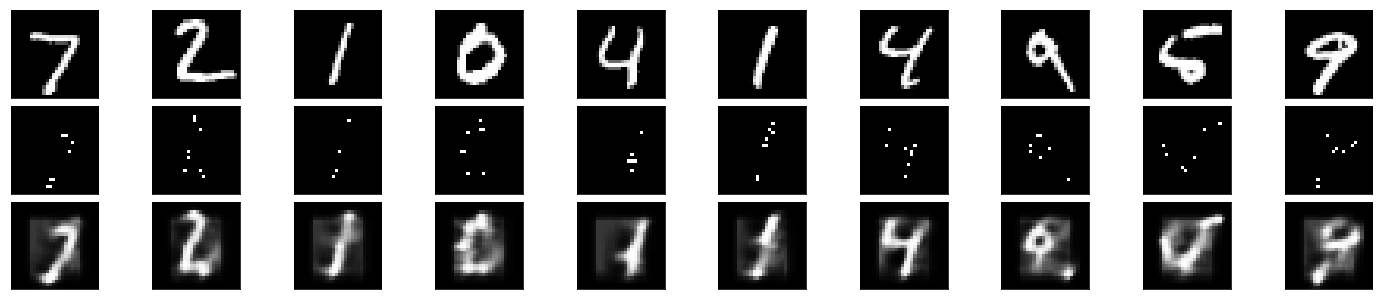

In [17]:
fig, axes = plt.subplots(nrows=3, ncols=10, sharex=True, sharey=True, figsize=(20,4))
in_imgs = mnist.test.images[0:10]
encoding= sess.run(encoded, feed_dict={inputs_: in_imgs.reshape((10, 28, 28, 1))})
reconstructed = sess.run(decoded, feed_dict={inputs_: in_imgs.reshape((10, 28, 28, 1))})

for images, row in zip([in_imgs, encoding, reconstructed], axes):
    for img, ax in zip(images, row):
        ax.imshow(img.reshape((28, 28)), cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)


fig.tight_layout(pad=0.1)

In [ ]:
sess.close()

# Conclusion

Images on top: Input data
Images in the middle: The latent space
Images on the bottom: Model output

It works, the latent space is human-friendly, but the model is not good enough to be used in any serious application.

As the next step i will instead experiment with VAE-GAN networks, which has proven to be able to do very good parametrization of the MNIST dataset.

http://blog.otoro.net/2016/04/01/generating-large-images-from-latent-vectors/

If a user interface is added on top of a model like this, maybe i can achive the similar but better result than this experiment?